## Predicting WIFI channels using some M.L. models

### Import required modules and load data file

In [52]:
%matplotlib notebook 

import numpy as np #linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline # put features in the pipeline:
import graphviz 
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.decomposition import PCA 

import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

#better numerical visualization
pd.set_option("display.precision", 2)
%config InlineBackend.figure_format = 'retina'

### Load data

In [210]:
df = pd.read_csv('gw_only.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   sourceRef                              76 non-null     object 
 1   chanUtilizations.radio24.1             76 non-null     float64
 2   chanUtilizations.radio24.10            71 non-null     float64
 3   chanUtilizations.radio24.11            76 non-null     float64
 4   chanUtilizations.radio24.12            70 non-null     float64
 5   chanUtilizations.radio24.13            71 non-null     float64
 6   chanUtilizations.radio24.14            70 non-null     float64
 7   chanUtilizations.radio24.2             71 non-null     float64
 8   chanUtilizations.radio24.3             71 non-null     float64
 9   chanUtilizations.radio24.4             71 non-null     float64
 10  chanUtilizations.radio24.5             71 non-null     float64
 11  chanUtil

### Examining the data

#### General Statistics

<IPython.core.display.Javascript object>


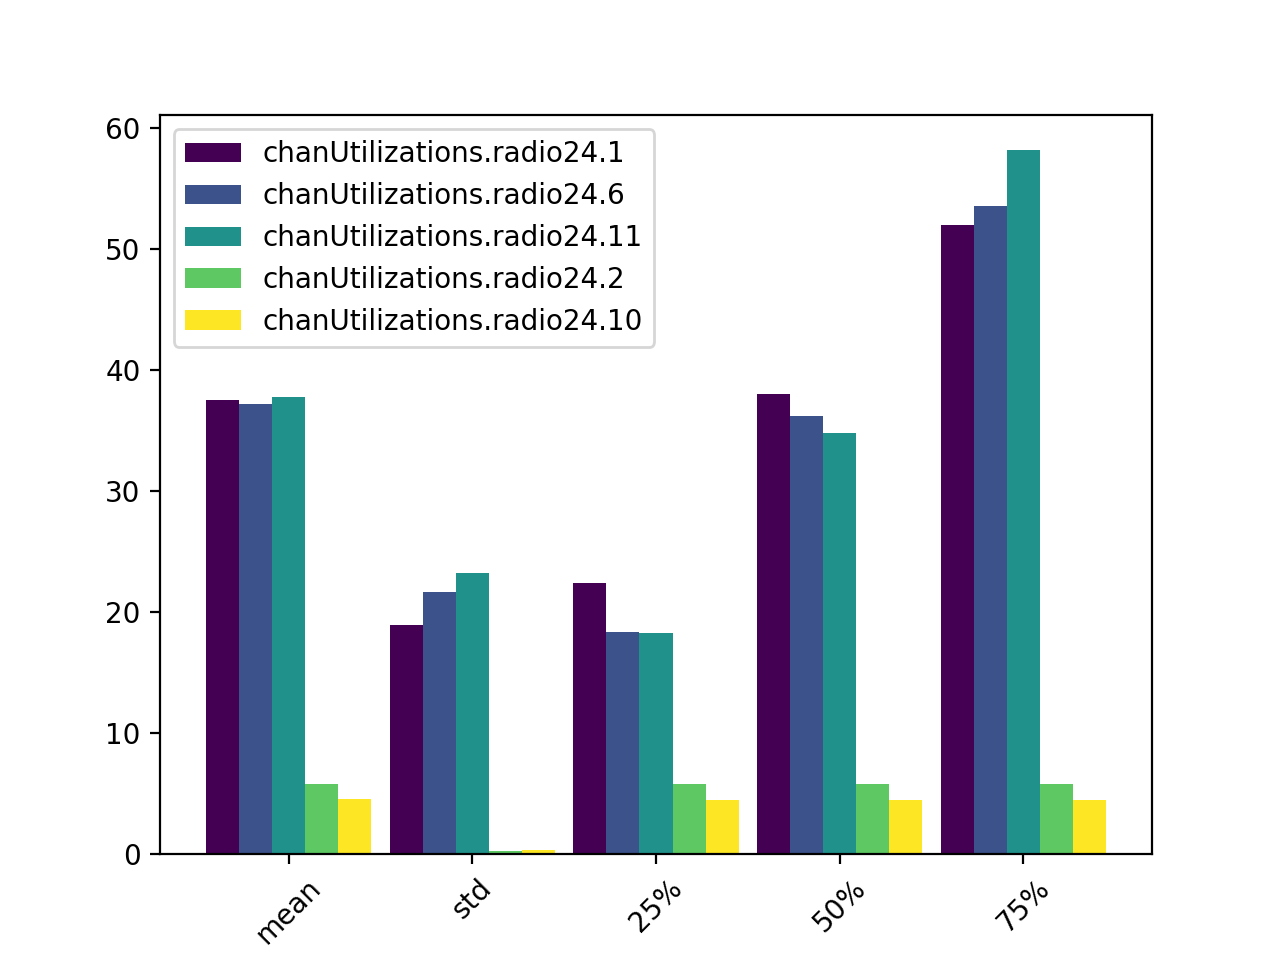

In [214]:
df[['chanUtilizations.radio24.1', 'chanUtilizations.radio24.6', 'chanUtilizations.radio24.11', \
    'chanUtilizations.radio24.2', 'chanUtilizations.radio24.10']].\
describe().\
drop(['count', 'min', 'max']).plot(kind='bar', colormap = 'viridis', width = 0.9)
plt.xticks(rotation =45)
plt.show()

### Preprocessing step: 
#### Look for NaN

In [4]:
# features containing nan values only
#df.isna().sum()[df.isna().sum() != 0]

<IPython.core.display.Javascript object>


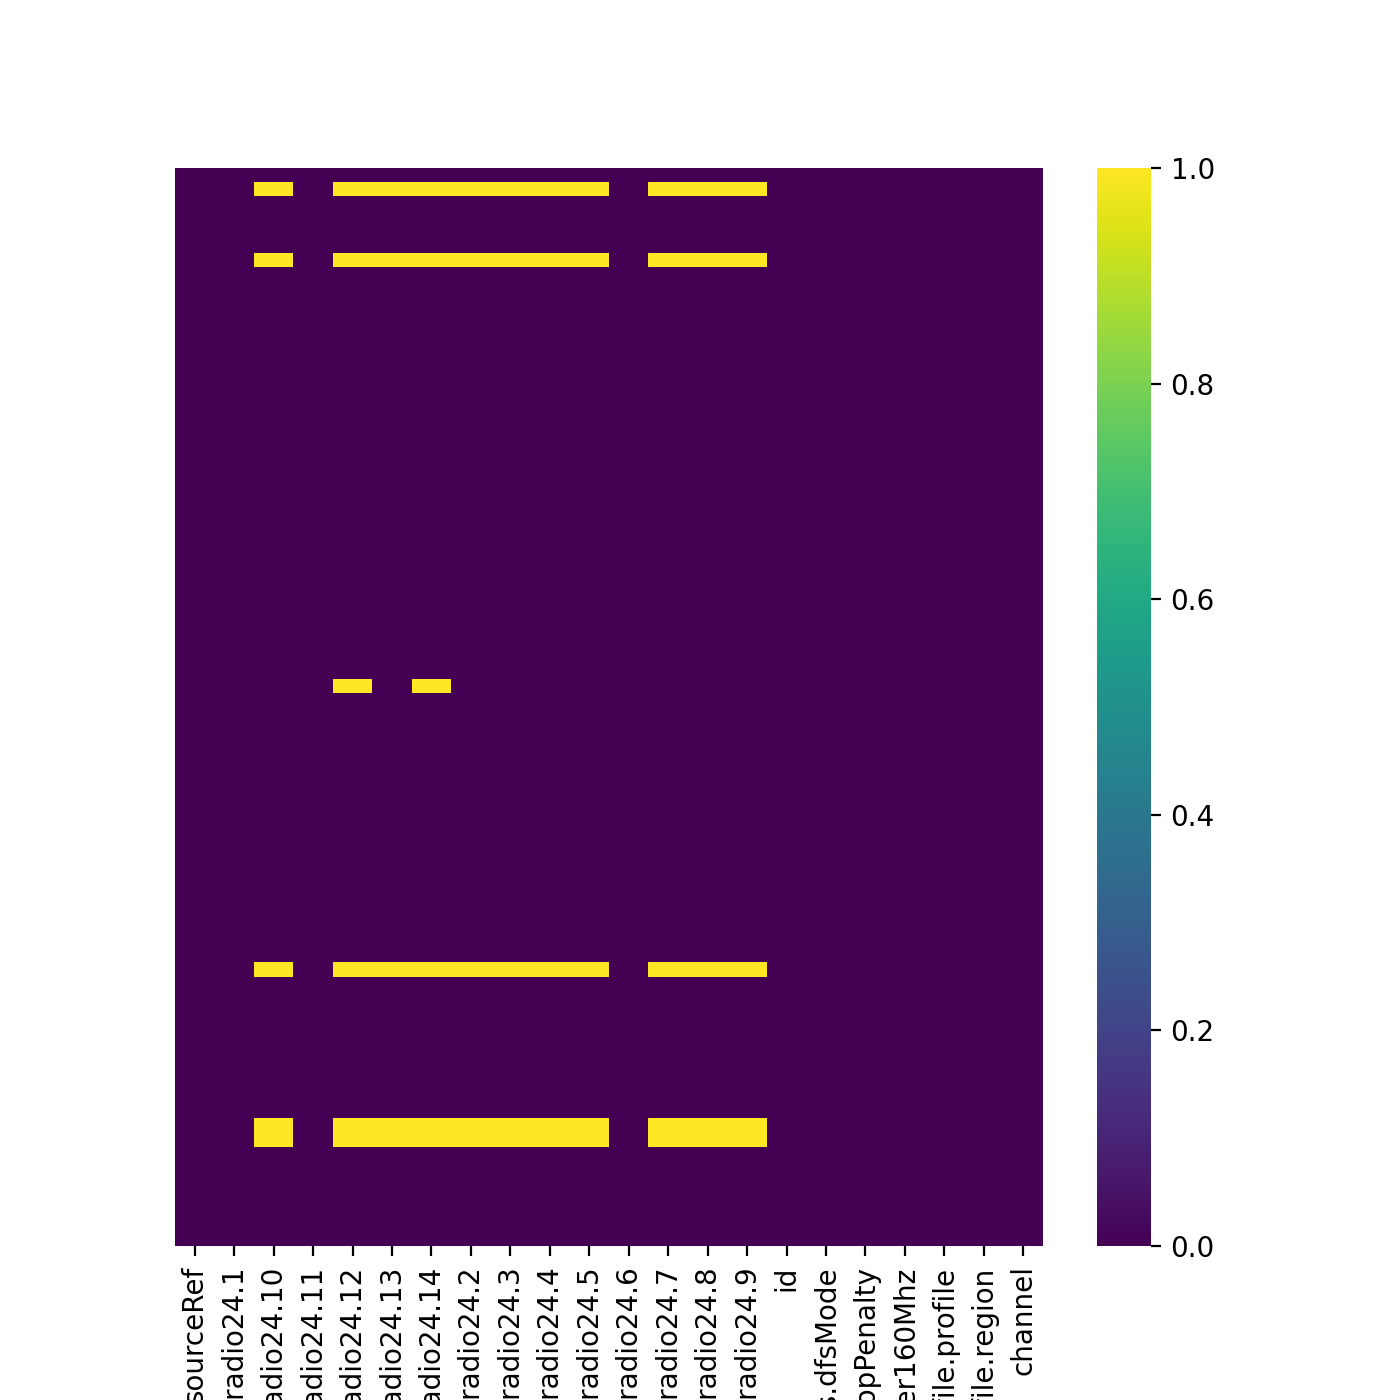

In [256]:
# Visualize the distribution of missing values in each column
%matplotlib notebook
plt.figure(figsize=(7,7))
sns.heatmap(df.isna(), cmap='viridis')
plt.yticks([])
#plt.tight_layout()
plt.show()

### check if the category features are multiclass or not

### check if the category features are multiclass or not

<IPython.core.display.Javascript object>


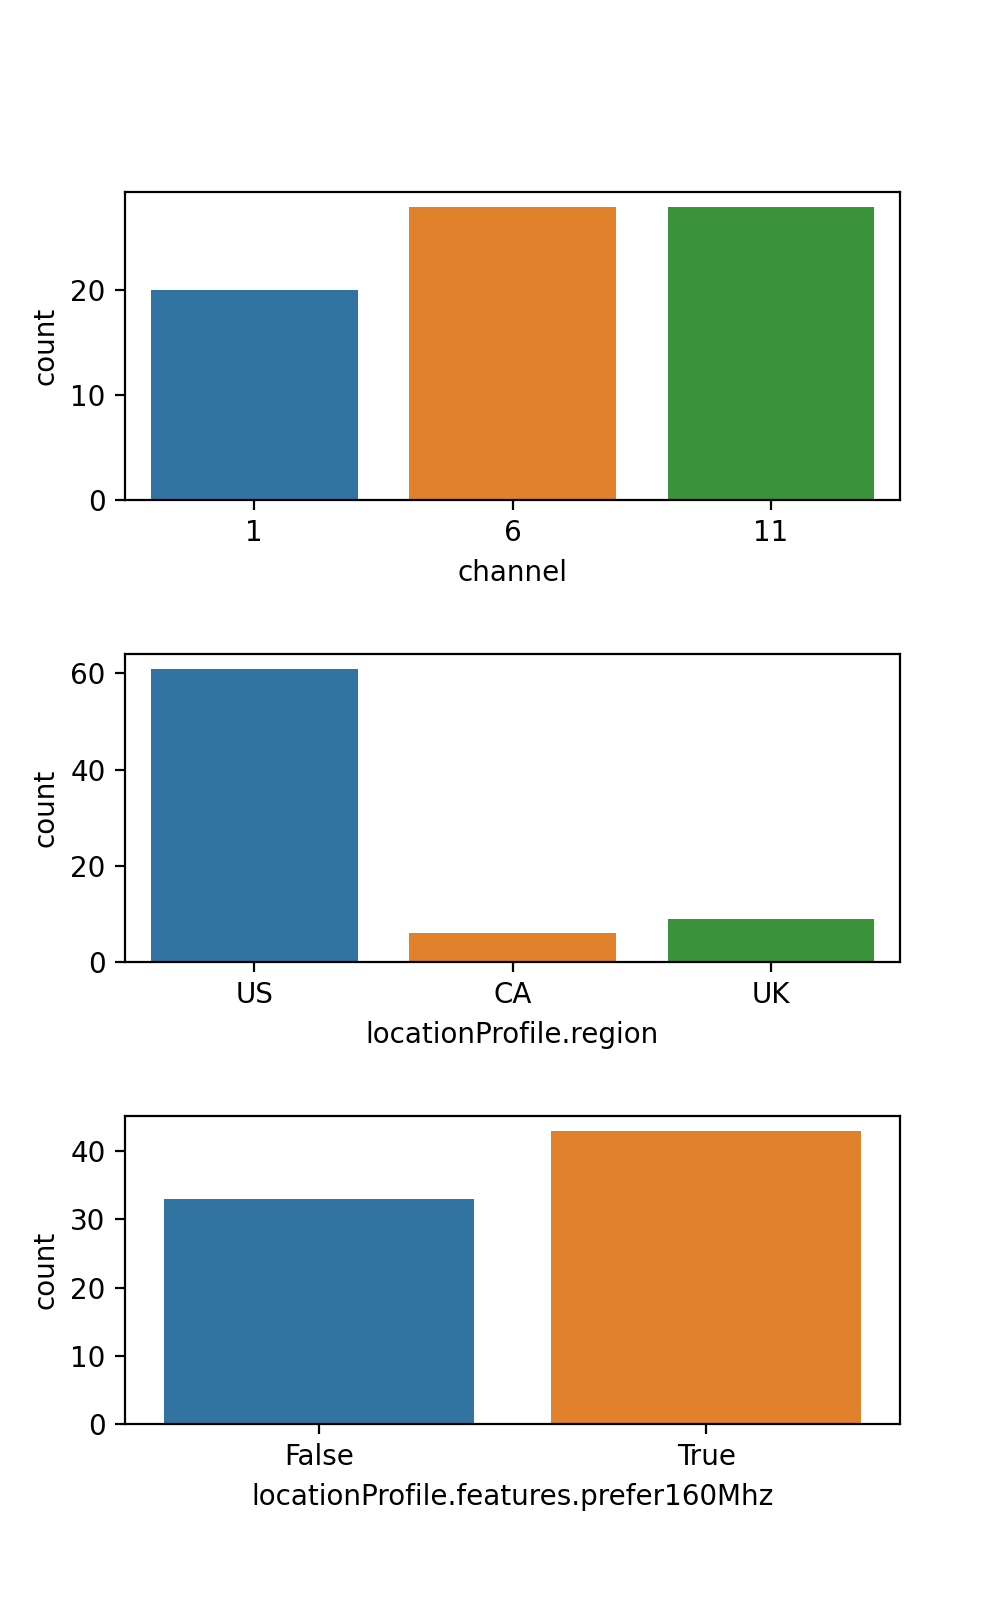

In [232]:
#Make the above plots more readable
fig, axes = plt.subplots(3, figsize=(5,8))

# First subplot: Total channel allocation
sns.countplot(x=df['channel'], ax=axes[0])
# Second subplot: Location profile
sns.countplot(x=df['locationProfile.region'], ax=axes[1])
# Third subplot: locationProfile.features.prefer160Mhz
sns.countplot(x=df['locationProfile.features.prefer160Mhz'], ax=axes[2])
plt.subplots_adjust(hspace=0.5)

plt.show()

### Drop features with no importance

In [90]:
#drop columns if no variation in the observation
df.drop(columns = ['locationProfile.features.dfsMode', 'locationProfile.features.hopPenalty', 'locationProfile.profile'], inplace=True)

# Drop names, id 
df.drop(columns=['sourceRef', 'id'], inplace=True)

### Examine the distribution 
#### Check if correlation between features exist

<IPython.core.display.Javascript object>


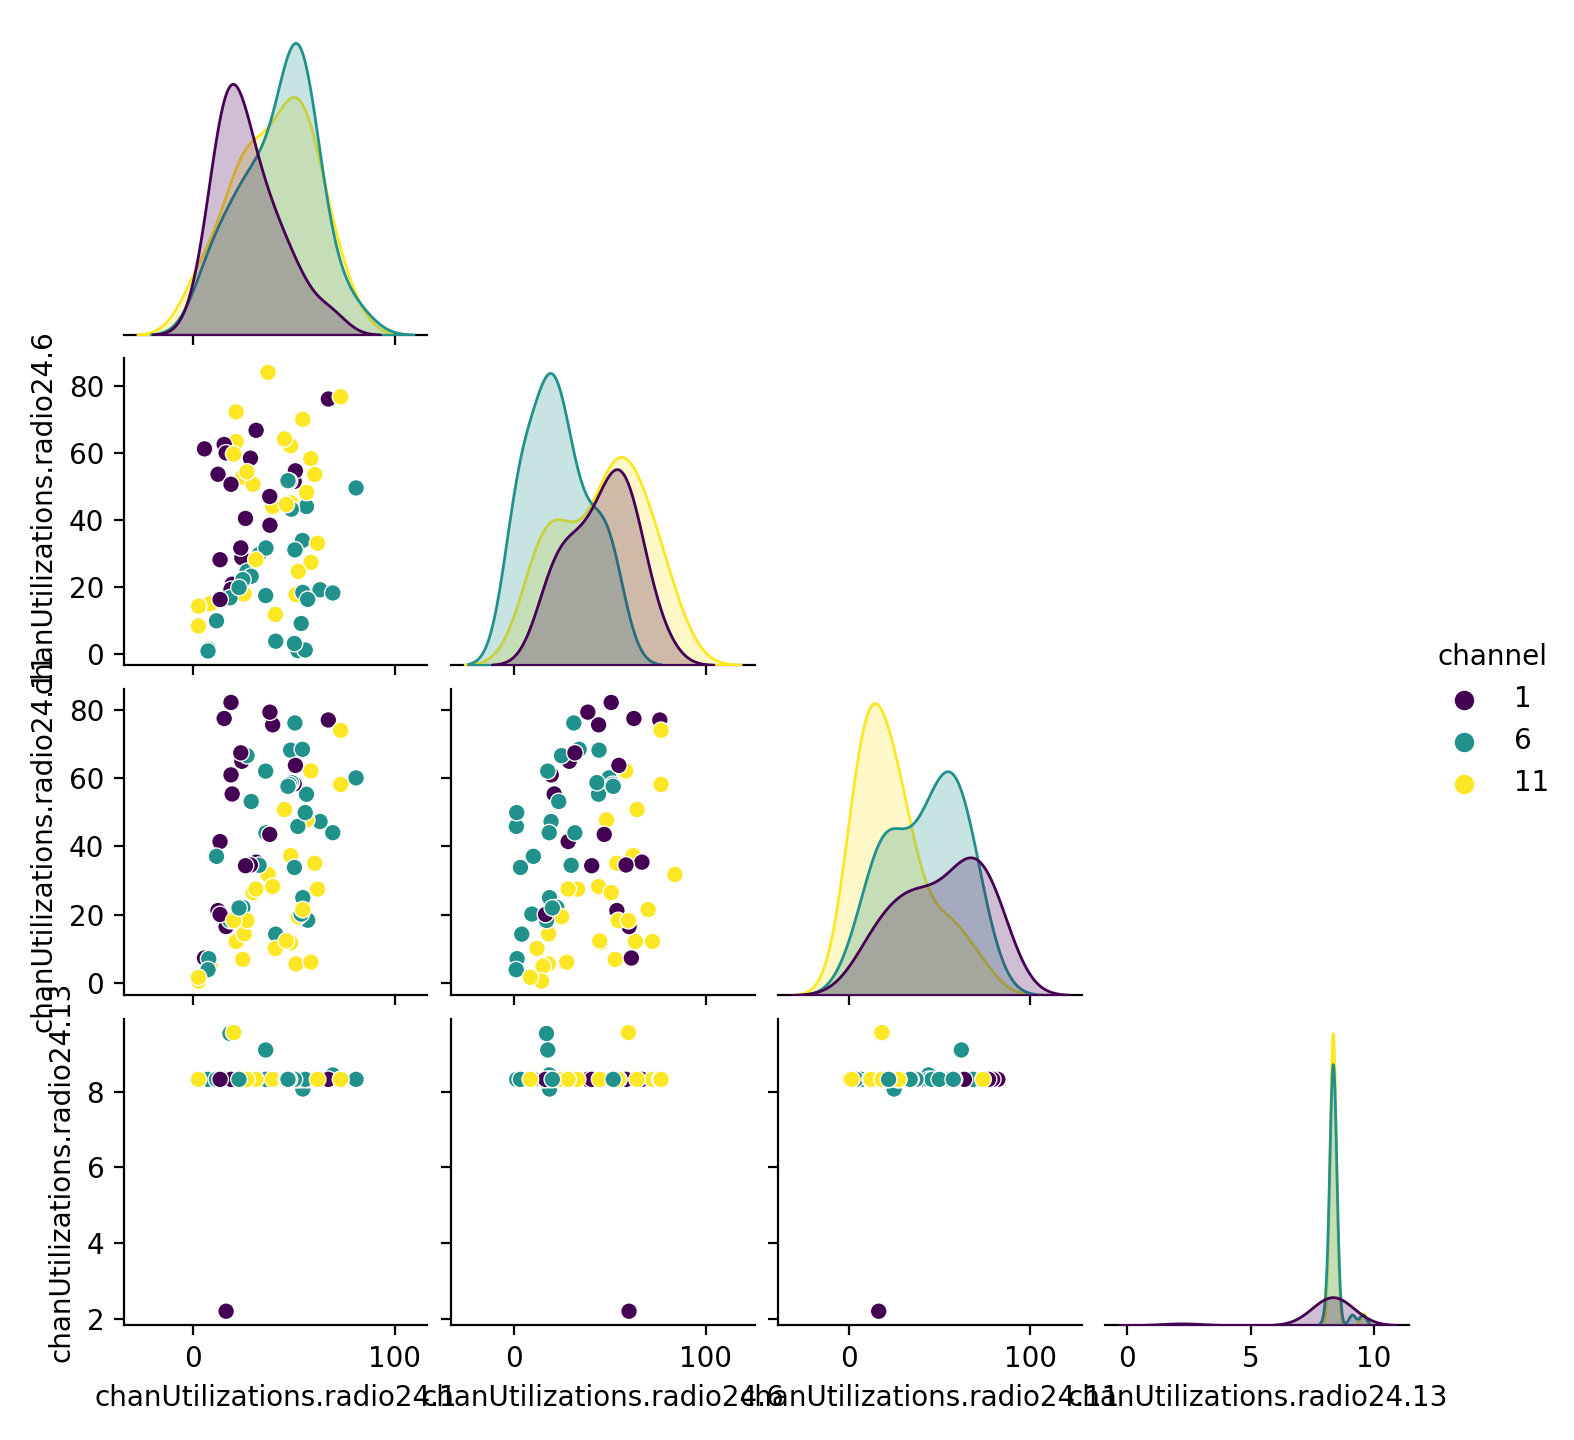

In [245]:
df2 = df[['chanUtilizations.radio24.1','chanUtilizations.radio24.6', 'chanUtilizations.radio24.11',
       'chanUtilizations.radio24.13', 'channel']]
sns.pairplot(df2, hue= 'channel', palette= 'viridis', corner='lower', size=1.8)
plt.show()

### Correlation Matrix
#### Weak correlations 
    cor ~ 0.7: strong
    cor ~ 0.5: mild
    cor ~ 0.3: weak
    since features with strong correlation are already remove

<IPython.core.display.Javascript object>


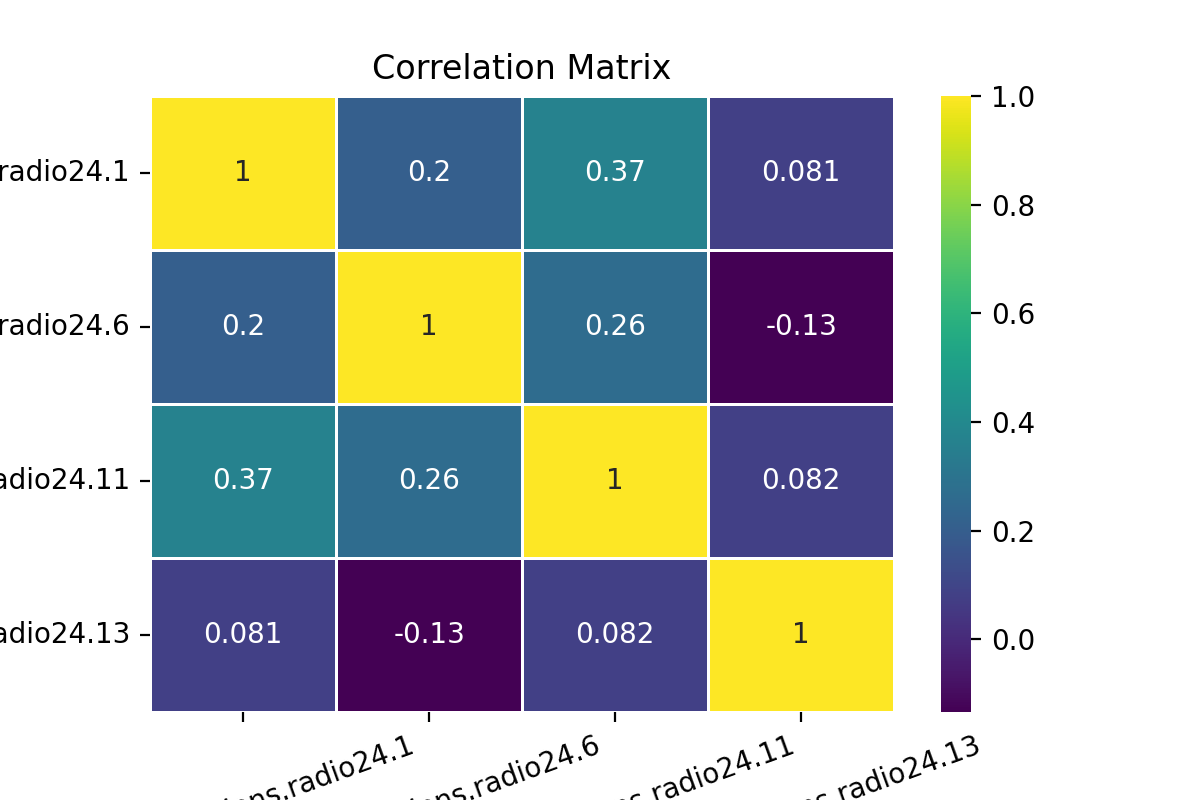

In [246]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(df2.drop('channel', axis=1).corr(), annot=True, cmap='viridis', linewidths=0.5)
plt.title('Correlation Matrix')
plt.xticks(rotation=20)
plt.show()

## Modeling

In [92]:
categorical_columns = ['locationProfile.region', 'locationProfile.features.prefer160Mhz']
numeric_columns = ['chanUtilizations.radio24.1', 'chanUtilizations.radio24.10',
       'chanUtilizations.radio24.11', 'chanUtilizations.radio24.12',
       'chanUtilizations.radio24.13', 'chanUtilizations.radio24.14',
       'chanUtilizations.radio24.2', 'chanUtilizations.radio24.3',
       'chanUtilizations.radio24.4', 'chanUtilizations.radio24.5',
       'chanUtilizations.radio24.6', 'chanUtilizations.radio24.7',
       'chanUtilizations.radio24.8', 'chanUtilizations.radio24.9',
                  ]
# columnTransformer: transform categorical and numerical features parallely
# ohe: use onehotencoder to transform categorical data
features = ColumnTransformer([
    ('categorical', OneHotEncoder(), categorical_columns),
    ('numeric', 'passthrough', numeric_columns)
])

### Training & validation sets

In [143]:
#feature selection
X = df.drop(columns=['channel'])
#target selection
y = df.channel.astype(dtype='category')
#split data into train and test sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y,random_state= 0, test_size=0.1)


print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_valid.shape:", X_valid.shape)
print("y_valid.shape:", y_valid.shape)

X_train.shape: (68, 16)
y_train.shape: (68,)
X_valid.shape: (8, 16)
y_valid.shape: (8,)


### create classifier
### 1. Decision tree
#### No need feature scaling

In [38]:
est = Pipeline([
    ('features', features),
    ('simpleimputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('clf', DecisionTreeClassifier())
])

In [39]:
gs = GridSearchCV(
    est,
    param_grid = {"clf__max_depth": range(1,4)},  
    cv=4, 
    verbose=3,
    n_jobs=2, 
)
gs.fit(X_train, y_train);
print("The best hyperparameter value is: ", gs.best_params_)

Fitting 4 folds for each of 3 candidates, totalling 12 fits
The best hyperparameter value is:  {'clf__max_depth': 3}


### k-fold Cross Validation algorithm used by GridSearchCV

This process we just performed by hand is automated by scikit-learn's GridSearchCV method. It takes a predictor and the hyperparameter ranges to test. Inside the fit method of the GridSearchCV method, cross-validation will be done to score each set of hyperparameters, and the best model will be selected and finally refit with the full data. After fitting, it has best_estimator_, best_params_, and best_score_ attributes set, and the predict method will call the best estimator (predictor).

### Metric: evaluation

In [11]:
print(f'Training accuracy: {gs.score(X_train, y_train):.3f}')
print('--------------')
print(f'Testing accuracy: {gs.score(X_valid, y_valid):.3f}')

Training accuracy: 0.794
--------------
Testing accuracy: 0.750


### Confusion Matrix

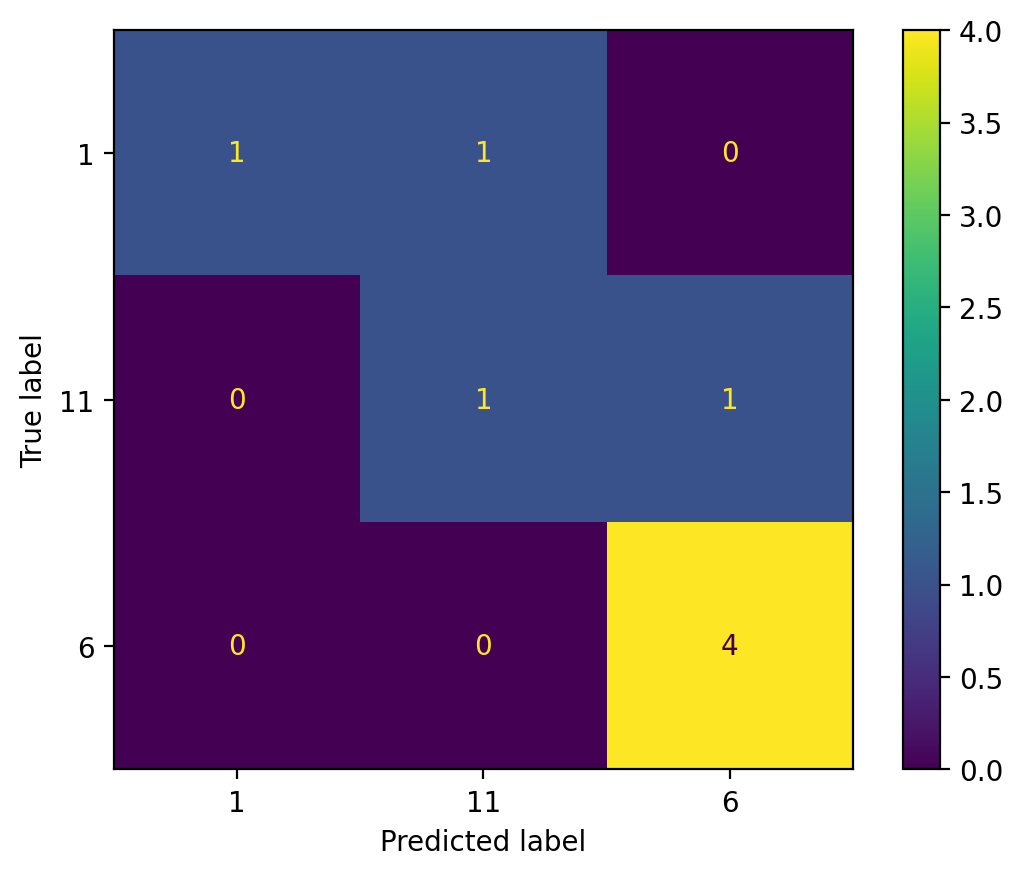

In [21]:
y_pred = gs.predict(X_valid)
cmf = confusion_matrix(y_valid, y_pred, )
ConfusionMatrixDisplay(confusion_matrix=cmf, display_labels=gs.classes_).plot()
plt.grid(False)
plt.show()

### Plot DT

In [40]:
# Get the best estimator/model from the GridSearchCV
best_model = gs.best_estimator_

# Get the features component in the pipeline
feature_names = best_model.named_steps['features'].get_feature_names_out()

#print("Final feature names:", feature_names)

shorter_featureNames = ['locCA', 'locUK', 'locUS', '160F', '160T',\
                       'radio24.1', 'radio24.10', 'radio24.11',\
                       'radio24.12', 'radio24.13',\
                       'radio24.14', 'radio24.2', 'radio24.3',\
                       'radio24.4', 'radio24.5', 'radio24.6',\
                       'radio24.7', 'radio24.8', 'radio24.9']

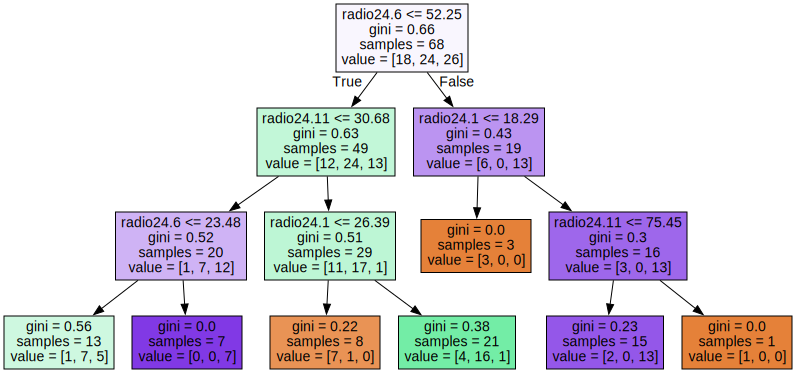

In [41]:
# Generate a plot of the decision tree
graphviz.Source(export_graphviz(decision_tree = best_model['clf'], out_file=None, 
                              feature_names = shorter_featureNames, precision = 2, filled=True))
#graph.render('/Users/slauda627/Desktop/decison_tree_best', format='png')

### Feature Importance

In [82]:
# Get the feature importances and feature names
feature_importances = best_model['clf'].feature_importances_
feature_names = best_model['features'].get_feature_names_out()

# Create a list of tuples (feature, importance) and sort it by importance in descending order
sorted_feature_importances = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)

# Print feature names with their importance values
print("Feature Importances (Non-zero):")
for feature, importance in sorted_feature_importances:
    if importance != 0:
        print(f"{feature}: {importance}")

Feature Importances (Non-zero):
numeric__chanUtilizations.radio24.6: 0.36203877388620803
numeric__chanUtilizations.radio24.1: 0.3451378506461919
numeric__chanUtilizations.radio24.11: 0.2928233754676002


## 2. Random Forest

In [83]:
rf_pipe = Pipeline([
    ('features', features),
    ('simpleimputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('rf', RandomForestClassifier(random_state=42, max_depth=4, max_features=3))
])

rf_gs = GridSearchCV(rf_pipe, 
                     cv=4, 
                     #verbose=3,
                     param_grid={'rf__min_samples_split': range(4,15)
                                }
                    )
rf_gs.fit(X_train, y_train);
print("The best hyperparameter value is: ", rf_gs.best_params_)

[CV 1/4] END ..................clf__max_depth=1;, score=0.471 total time=   0.0s
[CV 4/4] END ..................clf__max_depth=1;, score=0.353 total time=   0.0s
[CV 2/4] END ..................clf__max_depth=2;, score=0.529 total time=   0.0s
[CV 4/4] END ..................clf__max_depth=2;, score=0.412 total time=   0.0s
[CV 2/4] END ..................clf__max_depth=3;, score=0.588 total time=   0.0s
[CV 4/4] END ..................clf__max_depth=3;, score=0.353 total time=   0.0s
[CV 2/4] END ..................clf__max_depth=1;, score=0.412 total time=   0.0s
[CV 3/4] END ..................clf__max_depth=1;, score=0.353 total time=   0.0s
[CV 1/4] END ..................clf__max_depth=2;, score=0.529 total time=   0.0s
[CV 3/4] END ..................clf__max_depth=2;, score=0.412 total time=   0.0s
[CV 1/4] END ..................clf__max_depth=3;, score=0.647 total time=   0.0s
[CV 3/4] END ..................clf__max_depth=3;, score=0.412 total time=   0.0s
The best hyperparameter valu

In [84]:
print(f'Training accuracy: {rf_gs.score(X_train, y_train):.2f}')
print('--------------')
print(f'Validation accuracy: {rf_gs.score(X_valid, y_valid):.2f}')

Training accuracy: 0.93
--------------
Validation accuracy: 0.62


### Confusion Matrix

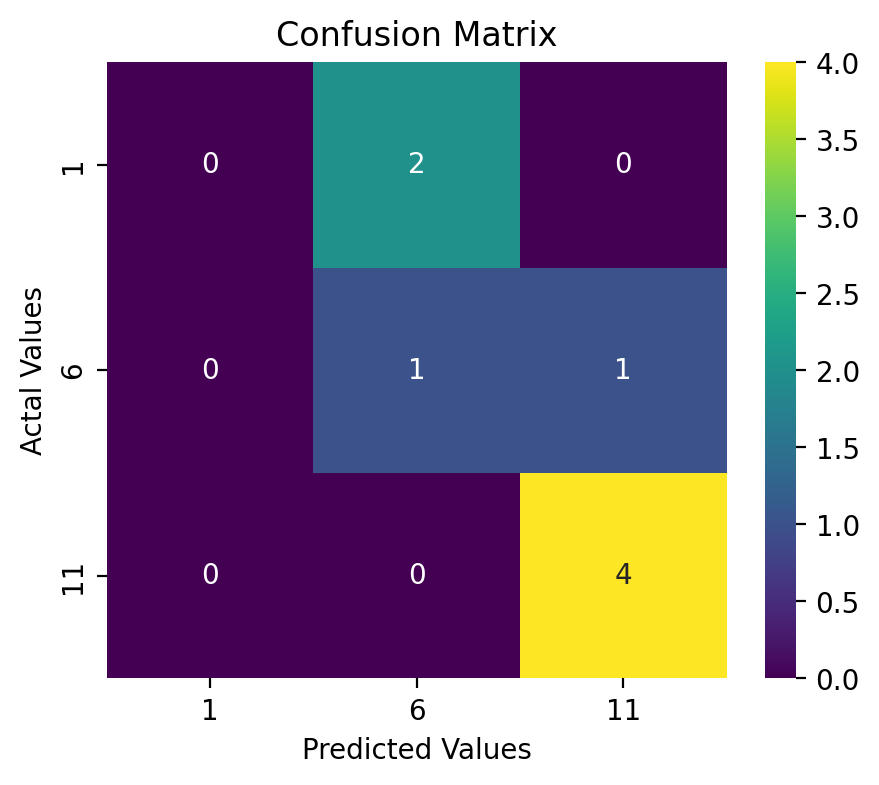

In [27]:
y_pred = rf_gs.predict(X_valid)
cm_df = pd.DataFrame(confusion_matrix(y_valid, y_pred),
                     index = ['1','6','11'], 
                     columns = ['1','6','11'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap= cmap)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

### Feature Importance

In [28]:
# Get the feature importances and feature names
feature_names = rf_gs.best_estimator_['features'].get_feature_names_out()
feature_importance = rf_gs.best_estimator_['rf'].feature_importances_

# Create a list of tuples (feature, importance) and sort it by importance in descending order
sorted_feature_importances = sorted(zip(feature_names, feature_importance), key=lambda x: x[1], reverse=True)

# Print feature names with their importance values
print("Feature Importances (Descending Order):")
for feature, importance in sorted_feature_importances:
    if importance > 0.05:
        print(f"{feature}: {importance:.3f}")

Feature Importances (Descending Order):
numeric__chanUtilizations.radio24.11: 0.270
numeric__chanUtilizations.radio24.6: 0.230
numeric__chanUtilizations.radio24.1: 0.141


## 3. Logistic Regression
    Need scaling otherwise convergence warning: lbfgs failed to converge & total no. of iterations reached limit
    Using k = 16, only considers channel 6 in the model

In [85]:
# For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss;

log_pipe = Pipeline([
    ('features', features),
    ('scaling', StandardScaler()),
    ('simpleimputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('selectK', SelectKBest(k=16)),
    ('lr', LogisticRegression(random_state=42, multi_class='multinomial', solver = 'lbfgs', max_iter = 100) )
])

log_pipe.fit(X_train, y_train);

# log_pipe.classes_ # list of class labels known to classifier
# log_pipe.named_steps['lr'].n_iter_ # no. of iterations for all classes

In [86]:
print(f'Training accuracy: {log_pipe.score(X_train, y_train):.2f}')
print('--------------')
print(f'Validation accuracy: {log_pipe.score(X_valid, y_valid):.2f}')

Training accuracy: 0.90
--------------
Validation accuracy: 0.75


### Confusion Matrix

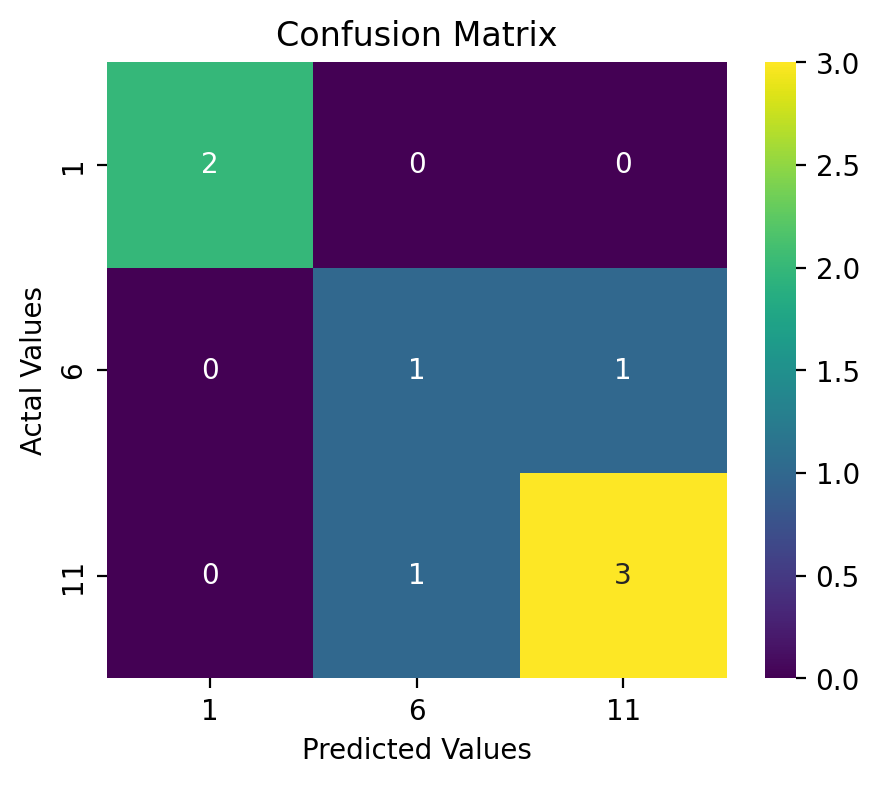

In [31]:
y_pred = log_pipe.predict(X_valid)
cm_df = pd.DataFrame(confusion_matrix(y_valid, y_pred),
                     index = ['1','6','11'], 
                     columns = ['1','6','11'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap= cmap)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

### Feature importance

In [32]:
# Get the feature importances and feature names
feature_names = log_pipe.named_steps['features'].get_feature_names_out()
feature_importance = abs(log_pipe.named_steps['lr'].coef_[0])

# Create a list of tuples (feature, importance) and sort it by importance in descending order
sorted_feature_importances = sorted(zip(feature_names, feature_importance), key=lambda x: x[1], reverse=True)

# Print feature names with their importance values
print("Feature Importances (Descending Order):")
for feature, importance in sorted_feature_importances:
    if importance > 0.1:
        print(f"{feature}: {importance:.3f}")

Feature Importances (Descending Order):
numeric__chanUtilizations.radio24.1: 1.680
numeric__chanUtilizations.radio24.11: 1.139
numeric__chanUtilizations.radio24.4: 0.784
numeric__chanUtilizations.radio24.12: 0.277
categorical__locationProfile.region_UK: 0.243
categorical__locationProfile.region_US: 0.209
numeric__chanUtilizations.radio24.14: 0.192
numeric__chanUtilizations.radio24.6: 0.172
numeric__chanUtilizations.radio24.3: 0.170
numeric__chanUtilizations.radio24.5: 0.143


## 4. Support Vector Classifier SVC
#### SVMs are not scale invariant, so it is highly recommended to scale your data.

In [87]:
svm_pipe = Pipeline([
    ('features', features),
    ('scaling', StandardScaler()),
    ('simpleimputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('svm', SVC())
])

svm_gs = GridSearchCV(svm_pipe, 
                     cv=5,
                      scoring = 'accuracy',
                      #verbose = 3,
                     param_grid={'svm__kernel': ['rbf', 'linear'], 
                                 'svm__C': [0.1, 1, 10],
                                 'svm__gamma': [0.1, 1, 10]
                                }                    )
svm_gs.fit(X_train, y_train);
print("The best hyperparameter value is: ", svm_gs.best_params_)

The best hyperparameter value is:  {'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'linear'}


In [88]:
print(f'Training accuracy: {svm_gs.score(X_train, y_train):.2f}')
print('--------------')
print(f'Validation accuracy: {svm_gs.score(X_valid, y_valid):.2f}')

Training accuracy: 0.91
--------------
Validation accuracy: 0.88


### Confusion Matrix

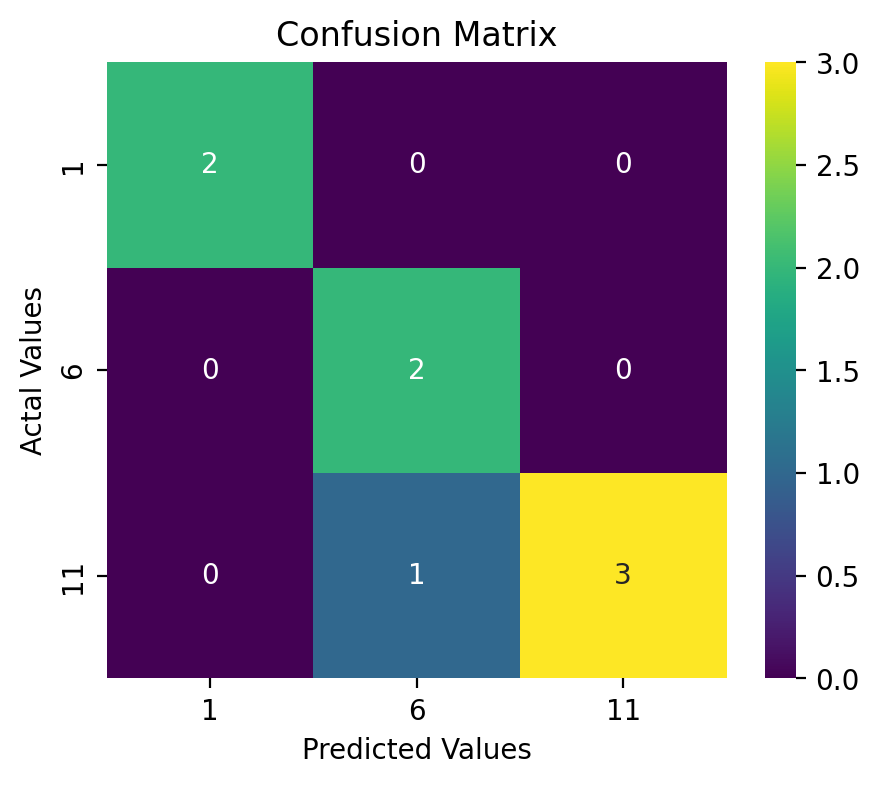

In [35]:
y_pred = svm_gs.predict(X_valid)
cm_df = pd.DataFrame(confusion_matrix(y_valid, y_pred),
                     index = ['1','6','11'], 
                     columns = ['1','6','11'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap= cmap)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

### Feature importance

In [36]:
svm_gs.best_estimator_

Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(),
                                                  ['locationProfile.region',
                                                   'locationProfile.features.prefer160Mhz']),
                                                 ('numeric', 'passthrough',
                                                  ['chanUtilizations.radio24.1',
                                                   'chanUtilizations.radio24.10',
                                                   'chanUtilizations.radio24.11',
                                                   'chanUtilizations.radio24.12',
                                                   'chanUtilizations.radio24.13',
                                                   'chanUtilization....14',
                                                   'chanUtilizations.radio24.2',
                                                   'chanUtilizations.radio24.3',
                                                   'chanUtilizations.radio24.4',
                                                   'chanUtilizations.radio24.5',
                                                   'chanUtilizations.radio24.6',
                                                   'chanUtilizations.radio24.7',
                                                   'chanUtilizations.radio24.8',
                                                   'chanUtilizations.radio24.9'])])),
                ('scaling', StandardScaler()),
                ('simpleimputer', SimpleImputer()),
                ('svm', SVC(C=10, gamma=0.1, kernel='linear'))])

In [37]:
# Get the learned coefficients (weights) from the SVM model
svm_weights = np.abs(svm_gs.best_estimator_['svm'].coef_)

# Compute feature importance scores as the sum of absolute weights across all classes
feature_importance = np.sum(svm_weights, axis=0)

# Sort the feature importance scores in descending order
sorted_indices = np.argsort(feature_importance)[::-1]

# Get the feature names or indices corresponding to the sorted feature importance
feature_names = best_model['features'].get_feature_names_out()

# Print the feature importance scores and corresponding feature names
for i in sorted_indices:
    if feature_importance[i] > 0.9:
        print(f"Feature: {feature_names[i]}, Importance: {feature_importance[i]}")


Feature: numeric__chanUtilizations.radio24.11, Importance: 9.565534216851493
Feature: numeric__chanUtilizations.radio24.1, Importance: 8.757537669634567
Feature: numeric__chanUtilizations.radio24.6, Importance: 8.631914517107157
Feature: numeric__chanUtilizations.radio24.8, Importance: 1.5117911001589066
Feature: numeric__chanUtilizations.radio24.7, Importance: 1.3829493331864708
Feature: numeric__chanUtilizations.radio24.13, Importance: 1.3715727096575623
Feature: numeric__chanUtilizations.radio24.2, Importance: 1.2606313776730333
Feature: numeric__chanUtilizations.radio24.10, Importance: 1.2539742096561346
Feature: numeric__chanUtilizations.radio24.4, Importance: 1.0878142591026112


### Compare different models

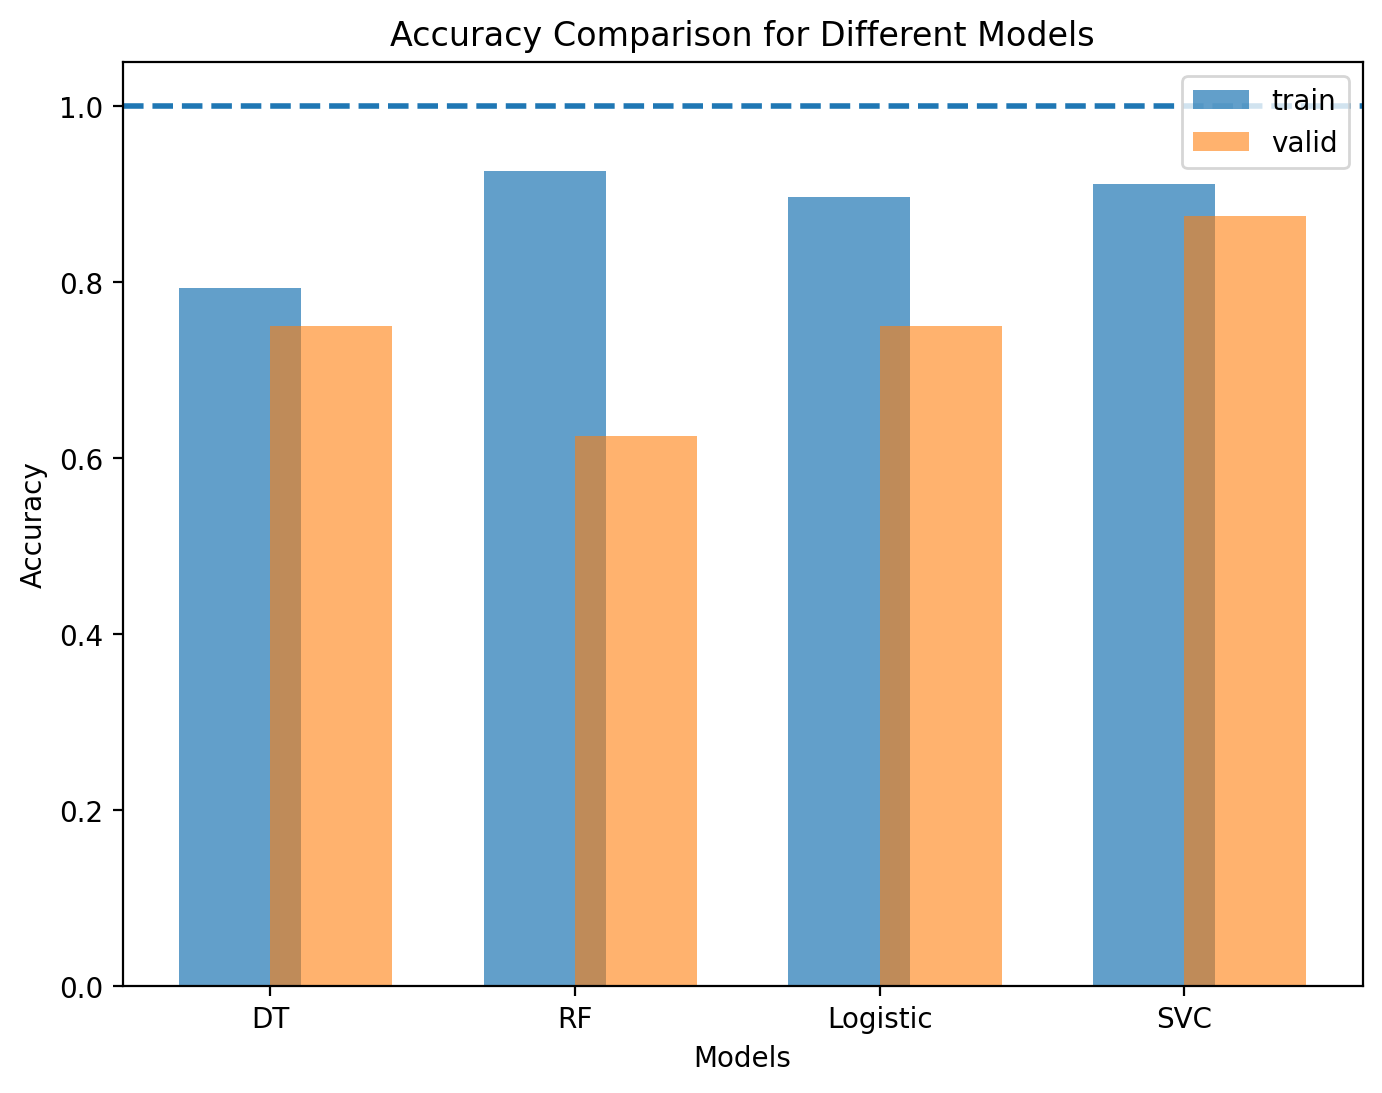

In [110]:
# Accuracy values for different models
barwidth =0.4
acc_train = [gs.score(X_train, y_train), rf_gs.score(X_train, y_train), log_pipe.score(X_train, y_train), svm_gs.score(X_train, y_train)]
acc_valid = [gs.score(X_valid, y_valid), rf_gs.score(X_valid, y_valid), log_pipe.score(X_valid, y_valid), svm_gs.score(X_valid, y_valid)]

shift=0.3
plt.figure(figsize=(8, 6))
plt.title('Accuracy Comparison for Different Models')
plt.bar(np.arange(len(acc_train)), acc_train,width=barwidth, label = 'train', alpha=0.7)
plt.bar(np.arange(len(acc_valid)) + shift, acc_valid, width=barwidth, label = 'valid', alpha=0.6)
plt.axhline(y=1, ls='--', lw=2)
plt.legend(loc = 'upper right')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks([_ + 0.1 for _ in range(len(acc_train))],
        ['DT', 'RF', 'Logistic', 'SVC'])
plt.show()

### Extra

In [13]:
from sklearn.ensemble import GradientBoostingRegressor as XGBoost

## XGBoost

In [ ]:
est = Pipeline([
    ('features', features),
    ('simpleimputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('clf', XGBoost())
])

In [27]:
xgb = GridSearchCV(
    est,
    param_grid = {"clf__max_depth": range(3, 7), "clf__n_estimators": range(95, 104)},  
    cv=4, 
    verbose=3,
    n_jobs=2, 
)
xgb.fit(X_train, y_train);
print("The best hyperparameter value is: ", gs.best_params_)

Fitting 4 folds for each of 36 candidates, totalling 144 fits
The best hyperparameter value is:  {'clf__max_depth': 3, 'clf__n_estimators': 101}


### Metric: evaluation

In [25]:
print(f'Training accuracy: {xgb.score(X_train, y_train):.3f}')
print('--------------')
print(f'Testing accuracy: {xgsb.score(X_valid, y_valid):.3f}')

Training accuracy: 0.993
--------------
Testing accuracy: 0.380


## Principal Component Analysis

In [136]:
features = ColumnTransformer([
    ('numeric', 'passthrough', numeric_columns)
])

In [190]:
svm_pipe = Pipeline([
    ('features', features),
    ('scaling', StandardScaler()),
    ('simpleimputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
     ('pca', PCA(n_components=0.93)),  # Dimensionality reduction
    ('svm', SVC())
])

svm_gs = GridSearchCV(svm_pipe, 
                     cv=5,
                      scoring = 'accuracy',
                      #verbose = 3,
                     param_grid={'svm__kernel': ['rbf', 'linear'], 
                                 'svm__C': [0.1, 1, 10],
                                 'svm__gamma': [0.1, 1, 10]
                                }                    )
svm_gs.fit(X_train, y_train);
print("The best hyperparameter value is: ", svm_gs.best_params_)

The best hyperparameter value is:  {'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'linear'}


In [173]:
print(f'Training accuracy: {svm_gs.score(X_train, y_train):.2f}')
print('--------------')
print(f'Validation accuracy: {svm_gs.score(X_valid, y_valid):.2f}')

Training accuracy: 0.88
--------------
Validation accuracy: 1.00


In [202]:
pca = svm_gs.best_estimator_['pca']
ratio_sum = pca.explained_variance_ratio_.cumsum()

<IPython.core.display.Javascript object>


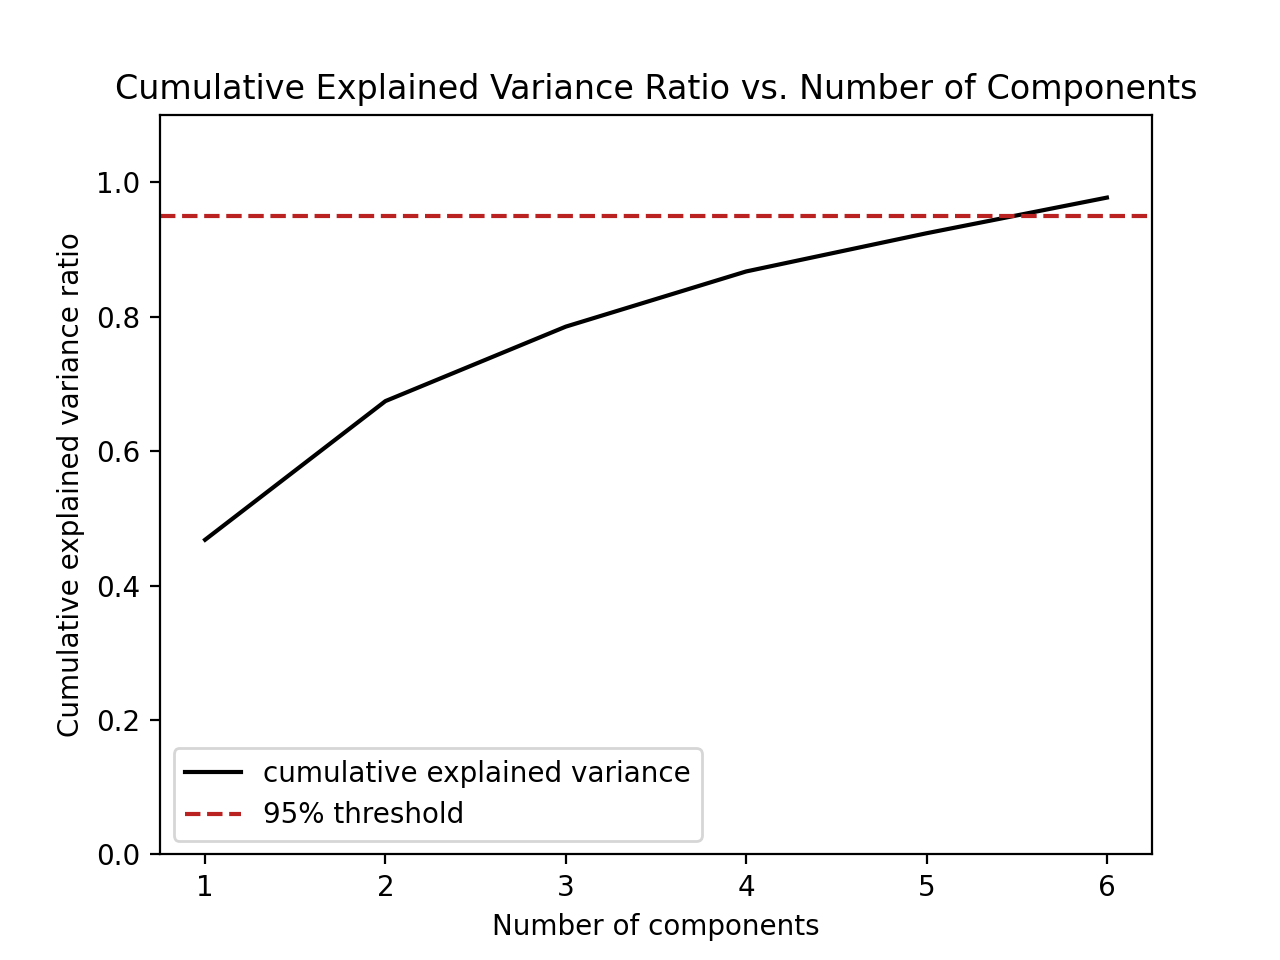

In [203]:
plt.figure()
plt.ylim(0, 1.1)
plt.plot(range(1, 7), ratio_sum, 'k', label='cumulative explained variance')
plt.axhline(y=0.95, linestyle='--', color='#ba2121ff', label='95% threshold')
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance ratio")
plt.title("Cumulative Explained Variance Ratio vs. Number of Components")
plt.legend();